# Kontrolna tačka 3 – Odabir algoritama i metrika uspešnosti, treniranje, validacija i testiranje + analiza rezultata

Treća kontrolna tačka predstavlja završnu fazu rada u kojoj se objedinuju teorijski koncepti i praktična implementacija modela. Nakon definisanja problema i izrade osnovnog modela u prethodnim fazama, cilj je da se kroz sistematičan pristup pokaže razumevanje kompletnog procesa razvoja modela mašinskog učenja.

U ovoj fazi poseban akcenat stavljen je na promišljen odabir algoritama i arhitektura koje su adekvatne za problem klasifikacije kožnih oboljenja, kao i na izbor metrika koje zaista imaju značaj u medicinskom kontekstu. Pored samog treniranja modela, naglasak je i na pravilnoj validaciji i testiranju, kako bi se obezbedila objektivna procena performansi.

Na kraju, rezultati se ne posmatraju samo kroz numeričke vrednosti, već se analiziraju sa kritičkim osvrtom – sa ciljem da se razume gde model daje stabilne rezultate, a gde postoje ograničenja i prostor za unapređenje.


## 1. Inicijalizacija i učitavanje podataka

In [ ]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, EfficientNetB3, VGG16
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("TensorFlow verzija:", tf.__version__)
print("GPU dostupan:", len(tf.config.list_physical_devices('GPU')) > 0)

TensorFlow verzija: 2.19.0
GPU dostupan: False


In [ ]:

drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/Skin_Disease_Classification/Split_smol"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")

print("TRAIN dir exists:", os.path.exists(TRAIN_DIR))
print("VAL dir exists:", os.path.exists(VAL_DIR))


Mounted at /content/drive
TRAIN dir exists: True
VAL dir exists: True


## 2. Odabir algoritama – Obrazloženje izbora

#### Zašto Transfer Learning?

Problem klasifikacije kožnih oboljenja predstavlja zahtevan zadatak vizuelne analitike, jer model mora da prepozna suptilne razlike između lezija koje često izgledaju veoma slično. S obzirom na to da dataset sadrži svega nekoliko stotina slika po klasi, treniranje duboke neuronske mreže od nule ne bi bilo optimalno rešenje.

Iz tog razloga odabran je pristup **transfer učenja (Transfer Learning)**. Ovaj pristup omogućava korišćenje modela koji su već trenirani na velikim skupovima podataka, poput ImageNet-a, gde su naučili osnovne vizuelne obrasce – ivice, teksture, oblike i kombinacije boja. Iako ImageNet ne sadrži medicinske slike, fundamentalne vizuelne karakteristike koje su ti modeli naučili korisne su i u domenu dermatoloških fotografija.

Pored toga, transfer učenje omogućava bržu konvergenciju tokom treniranja, stabilnije rezultate i manju potrebu za računarskim resursima. U kontekstu ograničenog skupa podataka i dostupne infrastrukture, ovaj pristup predstavlja razumno i efikasno rešenje.

#### Odabrane arhitekture

Arhitekture koje su dolazile u obrzir: **ResNet50**, **EfficientNetB3** i **VGG16**. Svaki od ovih modela ima svoje prednosti – ResNet50 koristi rezidualne veze koje omogućavaju treniranje dubljih mreža, EfficientNetB3 je poznat po dobrom balansu između tačnosti i efikasnosti, dok VGG16 predstavlja klasičnu i jednostavniju arhitekturu pogodnu za poređenje.

Nakon razmatranja navedenih opcija, odlučila sam da koristim **ResNet50** model. Ova arhitektura je široko korišćena u literaturi za klasifikaciju medicinskih slika i pokazuje stabilne performanse u zadacima višeklasne klasifikacije. Njena dubina i residualna struktura omogućavaju učenje kompleksnih reprezentacija, što je posebno važno kod vizuelno sličnih dermatoloških lezija.


## 3. Definisanje metrika uspešnosti

Pri evaluaciji modela za klasifikaciju kožnih oboljenja nije dovoljno osloniti se samo na jednu numeričku vrednost. S obzirom na medicinski karakter problema, izbor metrika mora biti pažljivo promišljen, jer različite vrste grešaka nemaju jednaku težinu.

U ovom radu korišćene su sledeće metrike:

1. **Accuracy** – predstavlja osnovnu metriku i pokazuje procenat ukupno tačno klasifikovanih uzoraka. Iako daje opštu sliku o performansama modela, sama po sebi nije dovoljna, posebno u situacijama kada postoji neuravnoteža klasa.

2. **Precision** – meri koliko su predikcije određene klase pouzdane. U kontekstu dermatologije, visoka preciznost znači da model retko pogrešno označava zdravu ili benignu promenu kao oboljenje, čime se smanjuje broj lažno pozitivnih slučajeva.

3. **Recall (osetljivost)** – pokazuje koliko dobro model prepoznaje stvarno obolele slučajeve. Ova metrika je posebno važna kod malignih oboljenja, jer je u medicinskoj praksi mnogo opasnije propustiti oboljenje nego generisati dodatnu proveru.

4. **F1-score** – predstavlja harmonijsku sredinu precision i recall vrednosti i daje balans između ove dve metrike. Korisna je kada je potrebno sagledati ukupnu stabilnost modela.

5. **ROC-AUC** – meri sposobnost modela da razdvoji klase na različitim pragovima odlučivanja i daje dodatni uvid u diskriminativnu moć modela.

6. **Confusion matrix** – omogućava vizuelni prikaz grešaka i pokazuje koje klase model najčešće meša, što je ključno za detaljnu analizu ponašanja modela.

7. **Per-class metrike** – analiza po pojedinačnim klasama omogućava preciznije razumevanje performansi, posebno u slučaju potencijalne neuravnoteže podataka.

Izbor ovih metrika zasnovan je na činjenici da je klasifikacija kožnih oboljenja problem medicinskog karaktera, gde pogrešne odluke mogu imati ozbiljne posledice. Zbog toga je neophodno koristiti balansirane metrike koje uzimaju u obzir i lažno pozitivne i lažno negativne slučajeve, kao i analizirati performanse po svakoj klasi pojedinačno.


### 4. Priprema podataka - Train/Val/Test split

### Strategija deljenja podataka

Kako bi se obezbedila objektivna i pouzdana evaluacija modela, primenila sam strategija podele podataka. Umesto da se originalni TRAIN i VAL folderi koriste odvojeno, sve slike sam najpre objedinila u jedinstveni skup, a zatim izvršila nova podela korišćenjem stratifikovanog pristupa.

Podaci su podeljeni u odnosu 70%–15%–15%, pri čemu 70% čini trening skup, 15% validacioni skup, a preostalih 15% test skup. Trening skup je korišćen uz data augmentaciju kako bi se povećala raznovrsnost uzoraka i smanjila mogućnost pretreniranja. Validacioni i test skup nisu podvrgnuti augmentaciji, jer je njihov zadatak da pruže realnu procenu performansi modela.

Stratifikovana podela omogućava da svaka klasa bude proporcionalno zastupljena u sva tri skupa, čime se izbegava pristrasnost u učenju i evaluaciji. Posebno je važno istaći da test skup nikada nije korišćen tokom treniranja, što omogućava nepristrasnu procenu sposobnosti modela da generalizuje na neviđene podatke.

Ovakav pristup doprinosi stabilnijem učenju, boljoj reprezentativnosti klasa i reproduktivnosti rezultata.


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
IMG_EXT = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

from tensorflow.keras.applications.resnet50 import preprocess_input

print("FAZA 1: Učitavanje svih slika iz TRAIN i VAL skupova...\n")


classes = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

all_images = []
all_labels = []

# Učitavanje slika iz TRAIN_DIR
for cls in classes:
    cls_dir = os.path.join(TRAIN_DIR, cls)
    train_count = len([f for f in os.listdir(cls_dir) if f.lower().endswith(IMG_EXT)])
    for img in os.listdir(cls_dir):
        if img.lower().endswith(IMG_EXT):
            all_images.append(os.path.join(cls_dir, img))
            all_labels.append(class_to_idx[cls])
    print(f"  TRAIN/{cls}: {train_count} slika")

# Učitavanje slika iz VAL_DIR
for cls in classes:
    cls_dir = os.path.join(VAL_DIR, cls)
    val_count = len([f for f in os.listdir(cls_dir) if f.lower().endswith(IMG_EXT)])
    for img in os.listdir(cls_dir):
        if img.lower().endswith(IMG_EXT):
            all_images.append(os.path.join(cls_dir, img))
            all_labels.append(class_to_idx[cls])
    print(f"  VAL/{cls}: {val_count} slika")

print(f"\nUkupan broj slika: {len(all_images)}")


all_images = np.array(all_images)
all_labels = np.array(all_labels)

print(f"\nFAZA 2: Deljenje na Train (70%), Validacija (15%), Test (15%)...\n")

# Prvi split: 70% train, 30% temp (za val+test)
from sklearn.model_selection import train_test_split

train_images, temp_images, train_labels, temp_labels = train_test_split(
    all_images, all_labels,
    test_size=0.30,
    random_state=42,
    stratify=all_labels
)

# Drugi split: 50% val, 50% test od temp skupa
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels,
    test_size=0.50,
    random_state=42,
    stratify=temp_labels
)

print(f"Train set: {len(train_images)} slika (70%)")
print(f"Val set:   {len(val_images)} slika (15%)")
print(f"Test set:  {len(test_images)} slika (15%)")
print(f"Ukupno:    {len(train_images) + len(val_images) + len(test_images)} slika")

print(f"\nDistribucija klasa po skupovima:")
print(f"\nTrain skup:")
for idx, cls in enumerate(classes):
    count = np.sum(train_labels == idx)
    print(f"  {cls}: {count}")

print(f"\nVal skup:")
for idx, cls in enumerate(classes):
    count = np.sum(val_labels == idx)
    print(f"  {cls}: {count}")

print(f"\nTest skup:")
for idx, cls in enumerate(classes):
    count = np.sum(test_labels == idx)
    print(f"  {cls}: {count}")

# FAZA 3: Kreiranje DataFrame-ova za flow_from_dataframe
import pandas as pd

print(f"\n\nFAZA 3: Pravljenje data generators-a...\n")

train_df = pd.DataFrame({
    'filename': train_images,
    'class': [classes[label] for label in train_labels]
})

val_df = pd.DataFrame({
    'filename': val_images,
    'class': [classes[label] for label in val_labels]
})

test_df = pd.DataFrame({
    'filename': test_images,
    'class': [classes[label] for label in test_labels]
})

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    shear_range=0.15,
    fill_mode='nearest'
)

# Bez augmentacije za validaciju i testiranje
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Kreiraj generatore
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

NUM_CLASSES = len(classes)
CLASS_NAMES = classes

print(f"Data generators kreirani!\n")
print(f"Broj klasa: {NUM_CLASSES}")
print(f"Klase: {CLASS_NAMES}")
print(f"\nTREIN skup: {train_generator.samples} slika")
print(f"VALIDACIJA skup: {val_generator.samples} slika")
print(f"TEST skup: {test_generator.samples} slika")
print(f"Batch size: {BATCH_SIZE}")

FAZA 1: Učitavanje svih slika iz TRAIN i VAL skupova...

  TRAIN/Actinic keratosis: 80 slika
  TRAIN/Atopic Dermatitis: 81 slika
  TRAIN/Benign keratosis: 80 slika
  TRAIN/Dermatofibroma: 80 slika
  TRAIN/Melanocytic nevus: 80 slika
  TRAIN/Melanoma: 80 slika
  TRAIN/Squamous cell carcinoma: 80 slika
  TRAIN/Tinea Ringworm Candidiasis: 56 slika
  TRAIN/Vascular lesion: 80 slika
  VAL/Actinic keratosis: 20 slika
  VAL/Atopic Dermatitis: 21 slika
  VAL/Benign keratosis: 20 slika
  VAL/Dermatofibroma: 20 slika
  VAL/Melanocytic nevus: 20 slika
  VAL/Melanoma: 20 slika
  VAL/Squamous cell carcinoma: 20 slika
  VAL/Tinea Ringworm Candidiasis: 20 slika
  VAL/Vascular lesion: 20 slika

Ukupan broj slika: 878

FAZA 2: Deljenje na Train (70%), Validacija (15%), Test (15%)...

Train set: 614 slika (70%)
Val set:   132 slika (15%)
Test set:  132 slika (15%)
Ukupno:    878 slika

Distribucija klasa po skupovima:

Train skup:
  Actinic keratosis: 70
  Atopic Dermatitis: 71
  Benign keratosis: 70
  

### Izračunavanje class weights

Iako je dataset relativno balansiran, primećuje se da pojedine klase (npr. *Tinea Ringworm Candidiasis*) imaju nešto manji broj uzoraka u odnosu na ostale. U takvim situacijama postoji rizik da model tokom treniranja daje veću važnost klasama koje su brojnije, dok slabije zastupljene klase budu zanemarene.

Zbog toga sam odlučila da ću da izračunavam **class weights**, odnosno težine koje model koristi tokom treniranja kako bi kompenzovao neuravnoteženost podataka. Funkcija compute_class_weight dodeljuje veću težinu klasama sa manjim brojem uzoraka, a manju težinu onima koje su brojnije.

Ove težine se zatim prosleđuju modelu tokom treniranja čime se osigurava da greške nad ređim klasama imaju veći uticaj na optimizaciju. Na taj način model uči ravnomernije i smanjuje se rizik da ignoriše slabije zastupljene kategorije.


In [ ]:

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = {i: w for i, w in enumerate(class_weights)}

print("Class weights:")
for k, v in class_weights.items():
    print(f"  {CLASS_NAMES[k]}: {v:.4f}")

Class weights:
  Actinic keratosis: 0.9746
  Atopic Dermatitis: 0.9609
  Benign keratosis: 0.9746
  Dermatofibroma: 0.9746
  Melanocytic nevus: 0.9746
  Melanoma: 0.9746
  Squamous cell carcinoma: 0.9746
  Tinea Ringworm Candidiasis: 1.2872
  Vascular lesion: 0.9746


### 5. Implementacija modela - Transfer Learning sa ResNet50

In [ ]:

def create_transfer_learning_model(base_model_name='resnet50', num_classes=NUM_CLASSES):
    """
    Pravi transfer learning model sa pre-trained bazom.

    Args:
        base_model_name: 'resnet50', 'efficientnet', ili 'vgg16'
        num_classes: broj klasa za klasifikaciju
    """

    # Učitavanje pre-trained baze
    if base_model_name == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        model_name = 'ResNet50'
    elif base_model_name == 'efficientnet':
        base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        model_name = 'EfficientNetB3'
    elif base_model_name == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        model_name = 'VGG16'
    else:
        raise ValueError("Nepoznat model")

    # Zamrzavanje baze tako da se ne trenira
    base_model.trainable = False

    # Kreiranje novog modela
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model, model_name

# Kreiranje modela
model_resnet, model_name_resnet = create_transfer_learning_model('resnet50')

# Prikaz strukture modela
print(f"\nModel: {model_name_resnet}")
print(f"Broj parametara (ukupno): {model_resnet.count_params():,}")
print(f"Broj trenabilnih parametara: {sum([tf.keras.backend.count_params(w) for w in model_resnet.trainable_weights]):,}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

Model: ResNet50
Broj parametara (ukupno): 24,770,441
Broj trenabilnih parametara: 1,182,729


In [ ]:
model_resnet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,770,441 (94.49 MB)

 Trainable params: 1,182,729 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### 6. Kompajliranje i treniranje modela

In [ ]:
# Kompajliranje modela
model_resnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model kompajliran")
print("Optimizer: Adam sa learning_rate=1e-4")
print("Loss funkcija: Categorical Cross-Entropy")
print("Metrike: Accuracy")

# Callback-ovi za bolju stabilnost treniranja
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]
print("Callbacks: EarlyStopping + ReduceLROnPlateau")

Model kompajliran
Optimizer: Adam sa learning_rate=1e-4
Loss funkcija: Categorical Cross-Entropy
Metrike: Accuracy
Callbacks: EarlyStopping + ReduceLROnPlateau


In [ ]:
# Treniranje (faza 1: zamrznuta baza)
print(f"\nPočinak treniranja sa {EPOCHS} epoha...\n")

history_resnet = model_resnet.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

print("\nTreniranje završeno!")


Počinak treniranja sa 30 epoha...

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 431s 21s/step - accuracy: 0.1363 - loss: 2.7899 - val_accuracy: 0.3864 - val_loss: 1.7274 - learning_rate: 1.0000e-04
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.2877 - loss: 1.9552 - val_accuracy: 0.5985 - val_loss: 1.3789 - learning_rate: 1.0000e-04
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.4145 - loss: 1.6884 - val_accuracy: 0.6364 - val_loss: 1.1802 - learning_rate: 1.0000e-04
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 90s 5s/step - accuracy: 0.5029 - loss: 1.4236 - val_accuracy: 0.7197 - val_loss: 1.0225 - learning_rate: 1.0000e-04
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - accuracy: 0.5746 - loss: 1.2072 - val_accuracy: 0.6970 - val_loss: 0.9288 - learning_rate: 1.0000e-04
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.5944 - loss: 1.2171 - val_accuracy: 0.7197 - val_loss: 0.8575 - learning_rate: 1.0000e-04
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 

Nakon završetka prve faze treniranja, u kojoj je bazni ResNet50 model bio u potpunosti zamrznut, postignute su stabilne performanse na validacionom skupu. U ovoj fazi trenirani su isključivo novododati klasifikacioni slojevi, dok su težine pretreniranog modela ostale nepromenjene. Ovakav pristup omogućava modelu da se najpre prilagodi novom zadatku bez rizika od destabilizacije već naučenih reprezentacija.

Međutim, kako bi se dodatno unapredile performanse i omogućilo modelu da se bolje prilagodi specifičnostima dermatoloških slika, primenila sam druga fazu – fine-tuning. U ovoj fazi deo dubokih slojeva baznog modela se odmrzava, čime se dozvoljava njihovo dodatno prilagođavanje ciljanom skupu podataka, uz smanjen learning rate radi stabilnijeg i kontrolisanog učenja.


In [ ]:
print("\nFine-tuning faza: odmrzavanje poslednjih 30 slojeva baze...")

base_model = next(l for l in model_resnet.layers if isinstance(l, tf.keras.Model))
print("Base model:", base_model.name, " | layers:", len(base_model.layers))

base_model.trainable = True

# Zamrzavanje svih osim poslednjih 30 slojeva
for layer in base_model.layers[:-30]:
    layer.trainable = False

# BN slojevi ostaju zamrznuti
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

fine_tune_epochs = 10

history_finetune = model_resnet.fit(
    train_generator,
    epochs=fine_tune_epochs,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

print("\nFine-tuning završen!")



Fine-tuning faza: odmrzavanje poslednjih 30 slojeva baze...
Base model: resnet50  | layers: 175
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 0.6660 - loss: 0.8991 - val_accuracy: 0.7500 - val_loss: 0.7397 - learning_rate: 1.0000e-05
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 126s 6s/step - accuracy: 0.6685 - loss: 0.8926 - val_accuracy: 0.7273 - val_loss: 0.6882 - learning_rate: 1.0000e-05
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 126s 6s/step - accuracy: 0.6601 - loss: 0.9020 - val_accuracy: 0.7652 - val_loss: 0.6558 - learning_rate: 1.0000e-05
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 129s 6s/step - accuracy: 0.7241 - loss: 0.8013 - val_accuracy: 0.7424 - val_loss: 0.6422 - learning_rate: 1.0000e-05
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 131s 7s/step - accuracy: 0.7142 - loss: 0.7720 - val_accuracy: 0.7424 - val_loss: 0.6308 - learning_rate: 1.0000e-05
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 126s 6s/step - accuracy: 0.7367 - loss: 0.6758 - val_accuracy: 0.7348 - val_loss: 0.6071 -

### 7. Prikaz rezultata treniranja - Loss i Accuracy

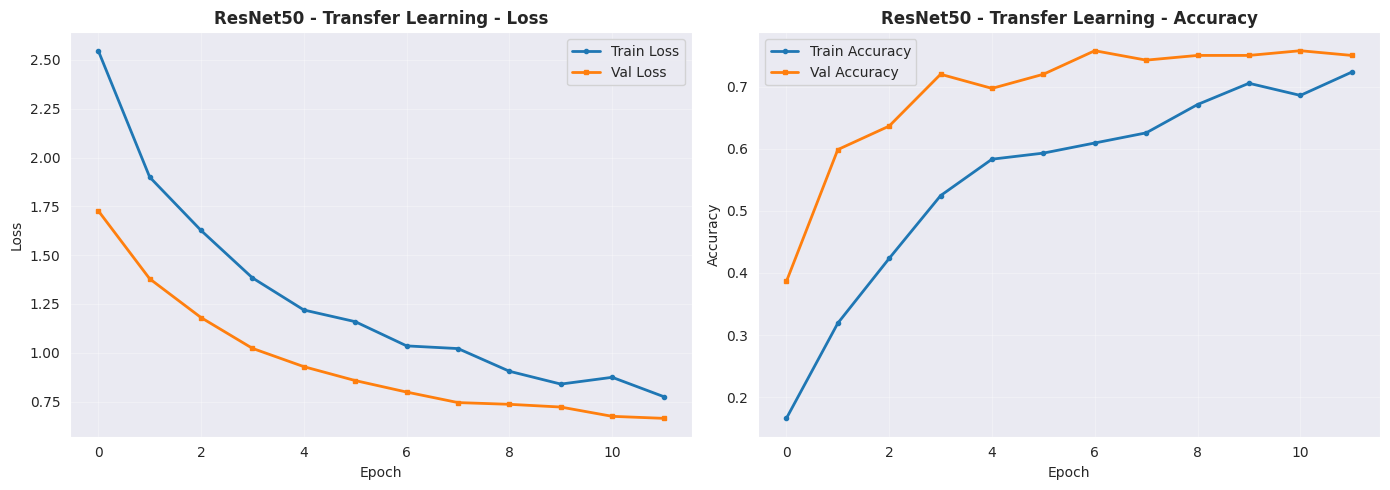

In [ ]:
def plot_training_history(history, title="Rezultati treniranja"):
    """
    Prikaži loss i accuracy tokom treniranja.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss
    ax1.plot(history.history['loss'], label='Train Loss', linewidth=2, marker='o', markersize=3)
    ax1.plot(history.history['val_loss'], label='Val Loss', linewidth=2, marker='s', markersize=3)
    ax1.set_title(f'{title} - Loss', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy
    ax2.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, marker='o', markersize=3)
    ax2.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2, marker='s', markersize=3)
    ax2.set_title(f'{title} - Accuracy', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history_resnet, "ResNet50 - Transfer Learning")

In [ ]:
# Fine-tuning (faza 3: još manje LR, odmrzavanje više slojeva)
print("\nFine-tuning faza 3: odmrzavanje poslednjih 50 slojeva baze...")


base_model = next(l for l in model_resnet.layers if isinstance(l, tf.keras.Model))
print("Base model:", base_model.name, " | layers:", len(base_model.layers))

base_model.trainable = True

# Odmrzavanje poslednjih 50 slojeva
for layer in base_model.layers[:-50]:
    layer.trainable = False

# BatchNorm ostaje zamrznut
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Ponovno kompajliranje modela sa jos manjim learning rate-om
model_resnet.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs_2 = 8

history_finetune_2 = model_resnet.fit(
    train_generator,
    epochs=fine_tune_epochs_2,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

print("\nFine-tuning faza 3 završena!")


Fine-tuning faza 3: odmrzavanje poslednjih 50 slojeva baze...
Base model: resnet50  | layers: 175
Epoch 1/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - accuracy: 0.7674 - loss: 0.6451 - val_accuracy: 0.7576 - val_loss: 0.5729 - learning_rate: 1.0000e-06
Epoch 2/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 126s 6s/step - accuracy: 0.7515 - loss: 0.6343 - val_accuracy: 0.7803 - val_loss: 0.5732 - learning_rate: 1.0000e-06
Epoch 3/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 126s 6s/step - accuracy: 0.7232 - loss: 0.6713 - val_accuracy: 0.7727 - val_loss: 0.5719 - learning_rate: 1.0000e-06
Epoch 4/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 126s 6s/step - accuracy: 0.7453 - loss: 0.6901 - val_accuracy: 0.7727 - val_loss: 0.5724 - learning_rate: 1.0000e-06
Epoch 5/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 128s 6s/step - accuracy: 0.7636 - loss: 0.6146 - val_accuracy: 0.7727 - val_loss: 0.5721 - learning_rate: 1.0000e-06
Epoch 6/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 127s 6s/step - accuracy: 0.7782 - loss: 0.6003 - val_accuracy: 0.7727 - val_loss: 0.5679 - lea

7.1 Prikaz rezultata treniranja - Loss i Accuracy

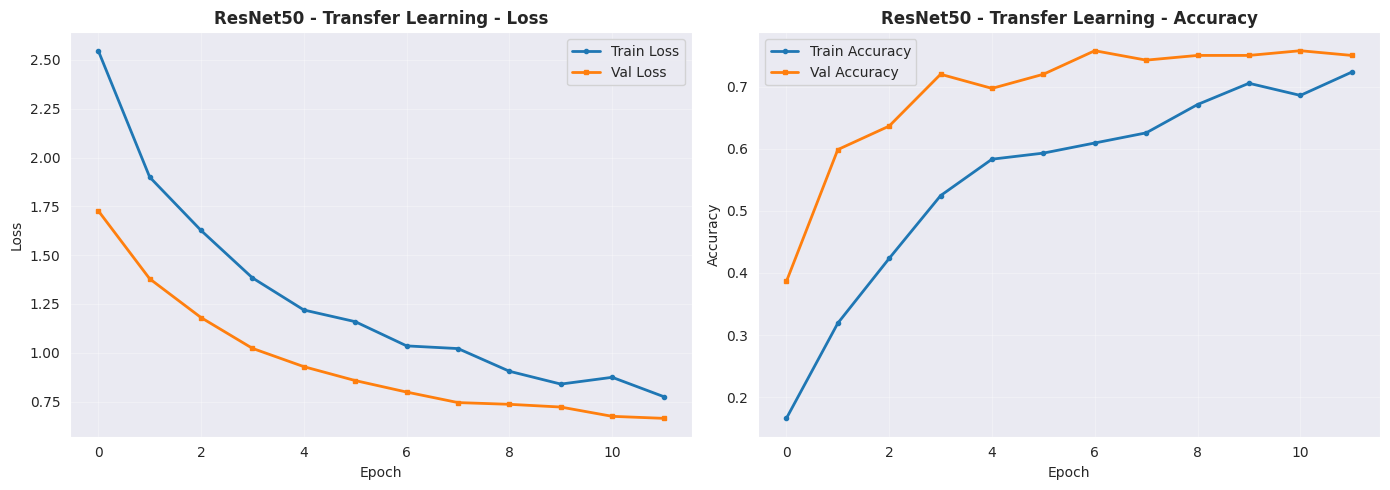

In [ ]:

def plot_training_history(history, title="Rezultati treniranja"):
    """
    Prikaži loss i accuracy tokom treniranja.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss
    ax1.plot(history.history['loss'], label='Train Loss', linewidth=2, marker='o', markersize=3)
    ax1.plot(history.history['val_loss'], label='Val Loss', linewidth=2, marker='s', markersize=3)
    ax1.set_title(f'{title} - Loss', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy
    ax2.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, marker='o', markersize=3)
    ax2.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2, marker='s', markersize=3)
    ax2.set_title(f'{title} - Accuracy', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history_resnet, "ResNet50 - Transfer Learning")

### 8. Evaluacija na validacionom skupu

In [ ]:
val_generator.reset()

print("Pravim predikcije na validacionom skupu...")
val_pred_probs = model_resnet.predict(val_generator)
val_pred = np.argmax(val_pred_probs, axis=1)
val_true = val_generator.classes

print(f"Broj predikcija: {len(val_pred)}")
print(f"Broj pravих labela: {len(val_true)}")

val_accuracy = np.mean(val_pred == val_true)
print(f"\nValidacioni Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

Pravim predikcije na validacionom skupu...
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step
Broj predikcija: 132
Broj pravих labela: 132

Validacioni Accuracy: 0.7803 (78.03%)


### 9. Detaljne metrike - Classification Report

In [ ]:
print("\n" + "="*80)
print("VALIDACIONI SKUP - DETALJNE METRIKE")
print("="*80 + "\n")

print(classification_report(
    val_true, val_pred,
    target_names=CLASS_NAMES,
    digits=4
))


VALIDACIONI SKUP - DETALJNE METRIKE

                            precision    recall  f1-score   support

         Actinic keratosis     0.8182    0.6000    0.6923        15
         Atopic Dermatitis     1.0000    0.8667    0.9286        15
          Benign keratosis     0.8000    0.8000    0.8000        15
            Dermatofibroma     0.7647    0.8667    0.8125        15
         Melanocytic nevus     0.8462    0.7333    0.7857        15
                  Melanoma     0.6154    0.5333    0.5714        15
   Squamous cell carcinoma     0.5000    0.6667    0.5714        15
Tinea Ringworm Candidiasis     0.9231    1.0000    0.9600        12
           Vascular lesion     0.8824    1.0000    0.9375        15

                  accuracy                         0.7803       132
                 macro avg     0.7944    0.7852    0.7844       132
              weighted avg     0.7915    0.7803    0.7804       132



### Analiza rezultata na validacionom skupu

Na validacionom skupu postignuta je ukupna tačnost od **78.03%**, što predstavlja solidan rezultat s obzirom na to da se radi o višeklasnoj klasifikaciji (9 klasa) i relativno malom broju slika. Pored same tačnosti, važno je pogledati i preciznost, odziv (recall) i F1-score po klasama, jer model ne pokazuje jednaku sigurnost za sve kategorije.

Najbolje performanse ostvarene su kod klasa **Tinea Ringworm Candidiasis** (F1 = 0.96) i **Vascular lesion** (F1 = 0.94), gde je recall čak **1.00**, što znači da model skoro nijedan primer ovih klasa nije propustio. Takođe, klasa **Atopic Dermatitis** ima veoma visoke rezultate (F1 = 0.93), što ukazuje da model dobro prepoznaje karakteristične obrasce za ove dijagnoze.

Srednje stabilne rezultate model postiže kod klasa poput **Benign keratosis** (F1 = 0.80), **Dermatofibroma** (F1 = 0.81) i **Melanocytic nevus** (F1 = 0.79), gde su precision i recall relativno uravnoteženi, što govori da model u tim slučajevima uglavnom pravi “razumne” predikcije.

Najslabije performanse uočavaju se kod klasa **Melanoma** i **Squamous cell carcinoma** (obe F1 ≈ 0.57). Posebno je važno istaći da je recall za **Melanoma** samo **0.53**, što znači da model propušta značajan broj melanoma u validacionom skupu. U medicinskom kontekstu ovo je kritično, jer lažno negativni slučajevi (kada se maligno oboljenje ne prepozna) mogu imati ozbiljne posledice.

Makro prosek F1-score-a je **0.7844**, dok je weighted prosek **0.7804**, što pokazuje da su performanse generalno stabilne, ali da pojedine klase i dalje predstavljaju izazov, posebno one koje su vizuelno slične drugim lezijama ili imaju suptilnije karakteristike.


### 10. Confusion Matrix - Validacioni skup

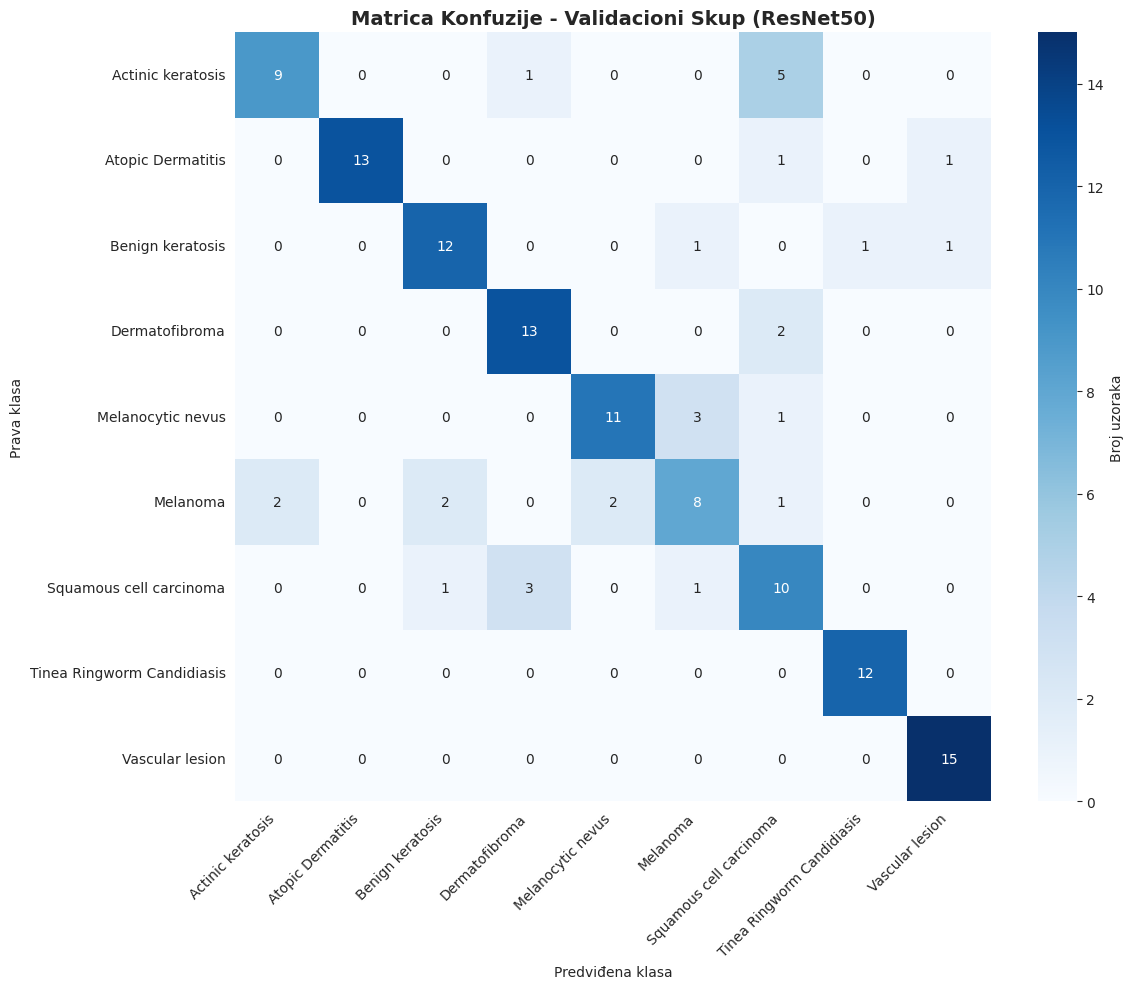

In [ ]:
cm_val = confusion_matrix(val_true, val_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Broj uzoraka'})
plt.title('Matrica Konfuzije - Validacioni Skup (ResNet50)', fontsize=14, fontweight='bold')
plt.xlabel('Predviđena klasa')
plt.ylabel('Prava klasa')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 11. Testiranje modela na TEST skupu

In [ ]:
print("Evaluacija na TEST skupu (15% od kombinovanih TRAIN+VAL)...\n")

test_generator.reset()
test_pred_probs = model_resnet.predict(test_generator)
test_pred = np.argmax(test_pred_probs, axis=1)
test_true = test_generator.classes
test_accuracy = np.mean(test_pred == test_true)

print(f"TEST Accuracy (15% od ukupnog): {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Broj uzoraka u TEST skupu: {len(test_true)}")

Evaluacija na TEST skupu (15% od kombinovanih TRAIN+VAL)...

5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step
TEST Accuracy (15% od ukupnog): 0.7197 (71.97%)
Broj uzoraka u TEST skupu: 132


### 11.1 Evaluacija na test skupu

Nakon završetka treniranja i validacije, model je evaluiran na potpuno odvojenom test skupu, koji čini 15% ukupnih podataka i nikada nije korišćen tokom procesa učenja. Ovaj skup predstavlja realnu procenu sposobnosti modela da generalizuje na neviđene podatke.

Na test skupu postignuta je tačnost od **71.97%**, na ukupno 132 uzorka. U poređenju sa validacionom tačnošću (78.03%), primećuje se blagi pad performansi, što je očekivano jer test podaci nisu učestvovali ni u treniranju ni u podešavanju hiperparametara.

Ovaj rezultat pokazuje da model poseduje solidnu generalizacionu sposobnost, ali i da postoji određeni prostor za unapređenje, posebno u pogledu stabilnosti performansi između validacionog i test skupa.


### 12. Confusion Matrix - Test skup (Odvojen, nikada viđen tokom treniranja)

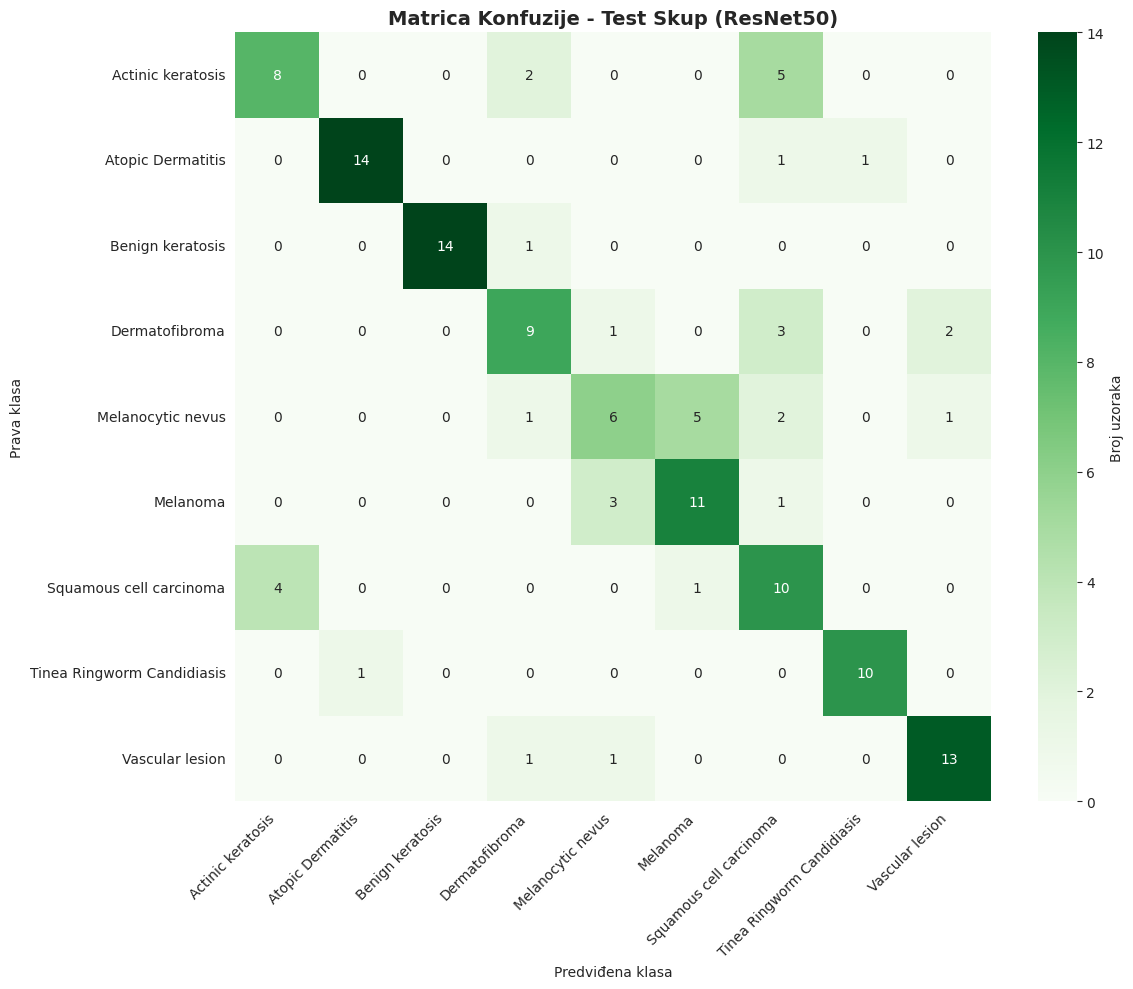

In [ ]:
cm_test = confusion_matrix(test_true, test_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Broj uzoraka'})
plt.title('Matrica Konfuzije - Test Skup (ResNet50)', fontsize=14, fontweight='bold')
plt.xlabel('Predviđena klasa')
plt.ylabel('Prava klasa')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 13. ROC-AUC Analiza

Pored standardnih metrika poput accuracy, precision i recall, u radu sam sprovela i ROC-AUC analiza kako bi se dodatno procenila sposobnost modela. ROC (Receiver Operating Characteristic) kriva prikazuje odnos između stope tačno pozitivnih slučajeva (True Positive Rate) i stope lažno pozitivnih slučajeva (False Positive Rate) pri različitim pragovima odlučivanja.

AUC (Area Under the Curve) predstavlja površinu ispod ROC krive i daje objedinjenu meru sposobnosti modela da razdvaja jednu klasu od ostalih. Vrednost AUC bliska 1 ukazuje na veoma dobru separaciju klasa, dok vrednost oko 0.5 označava performanse slične nasumičnom pogađanju.

S obzirom na to da je u pitanju višeklasni problem, primenjen je pristup *One-vs-Rest*, gde se svaka klasa pojedinačno posmatra kao pozitivna, dok se sve ostale klase tretiraju kao negativne. Na taj način dobijene su ROC krive i AUC vrednosti za svaku klasu zasebno, kao i njihov prosečan rezultat.

Ova analiza omogućava dublje razumevanje sposobnosti modela da razlikuje dermatološke kategorije, nezavisno od jednog fiksnog praga klasifikacije, što je posebno značajno u medicinskim primenama.


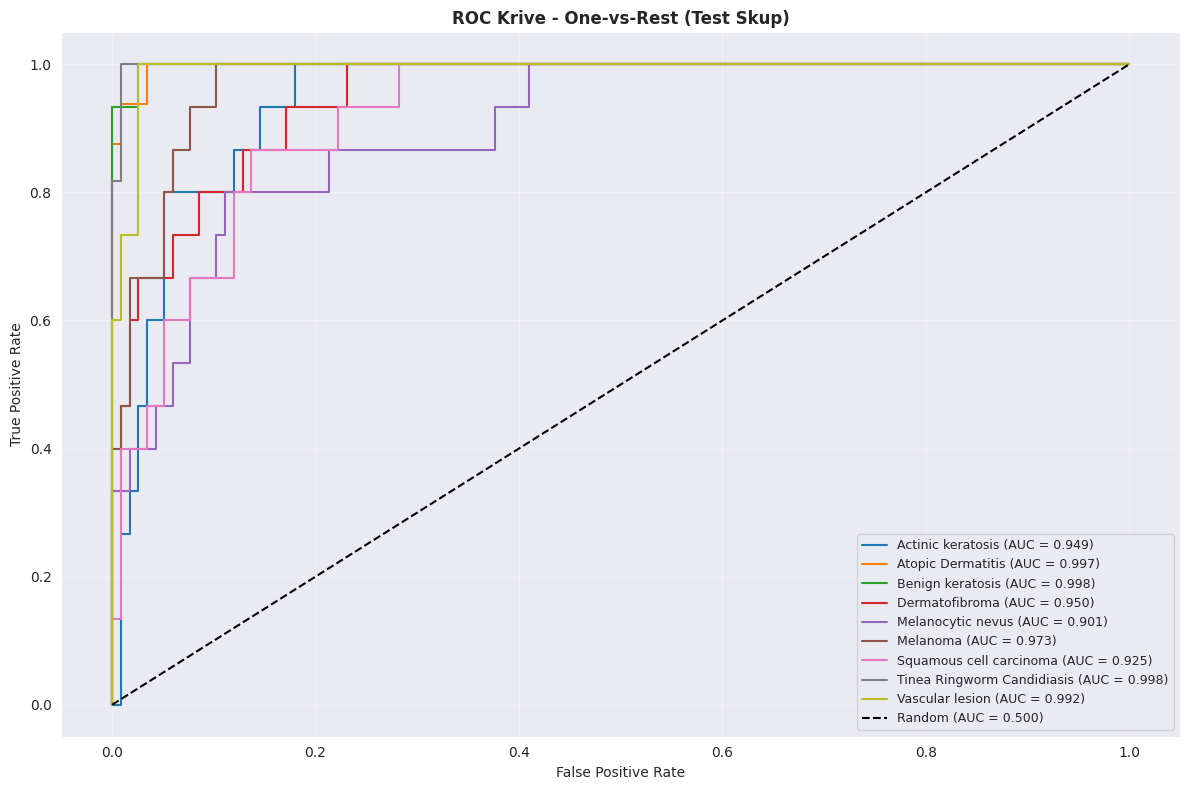


ROC-AUC Rezultati po klasama (Test skup):
  Tinea Ringworm Candidiasis: 0.9985
  Benign keratosis: 0.9983
  Atopic Dermatitis: 0.9973
  Vascular lesion: 0.9920
  Melanoma: 0.9732
  Dermatofibroma: 0.9499
  Actinic keratosis: 0.9487
  Squamous cell carcinoma: 0.9248
  Melanocytic nevus: 0.9009

Prosečan ROC-AUC: 0.9648


In [ ]:
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(test_true, classes=range(NUM_CLASSES))

roc_auc_scores = {}
plt.figure(figsize=(12, 8))

for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_probs[:, i])
    roc_auc_scores[CLASS_NAMES[i]] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{CLASS_NAMES[i]} (AUC = {roc_auc_scores[CLASS_NAMES[i]]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Krive - One-vs-Rest (Test Skup)', fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nROC-AUC Rezultati po klasama (Test skup):")
for cls_name, auc_val in sorted(roc_auc_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"  {cls_name}: {auc_val:.4f}")
print(f"\nProsečan ROC-AUC: {np.mean(list(roc_auc_scores.values())):.4f}")

### 13.1 Tumačenje ROC-AUC rezultata

ROC-AUC analiza na test skupu pokazuje da model ima veoma dobru sposobnost razdvajanja klasa, sa **prosečnim ROC-AUC = 0.9648**, što predstavlja visok rezultat za višeklasnu klasifikaciju. Ovo znači da model, gledano kroz raspodelu predikcionih verovatnoća i kroz različite pragove odlučivanja, u većini slučajeva uspešno “odvaja” jednu klasu od ostalih.

Važno je napomenuti da visoke ROC-AUC vrednosti ne moraju uvek direktno značiti i visoku tačnost (accuracy), jer AUC meri sposobnost razdvajanja klasa kroz pragove, dok accuracy zavisi od konkretne odluke pri izabranom pragu. Ipak, kombinovanjem ROC-AUC analize sa accuracy, F1-score i matricom konfuzije dobija se potpunija slika: model generalno dobro razlikuje većinu klasa, dok su najveći izazovi prisutni kod vizuelno sličnih kategorija.


### 14. Pregled Specifičnih Pogrešnih Klasifikacija


Ukupan broj pogrešnih predikcija: 37 od 132
Prikazujem: 15



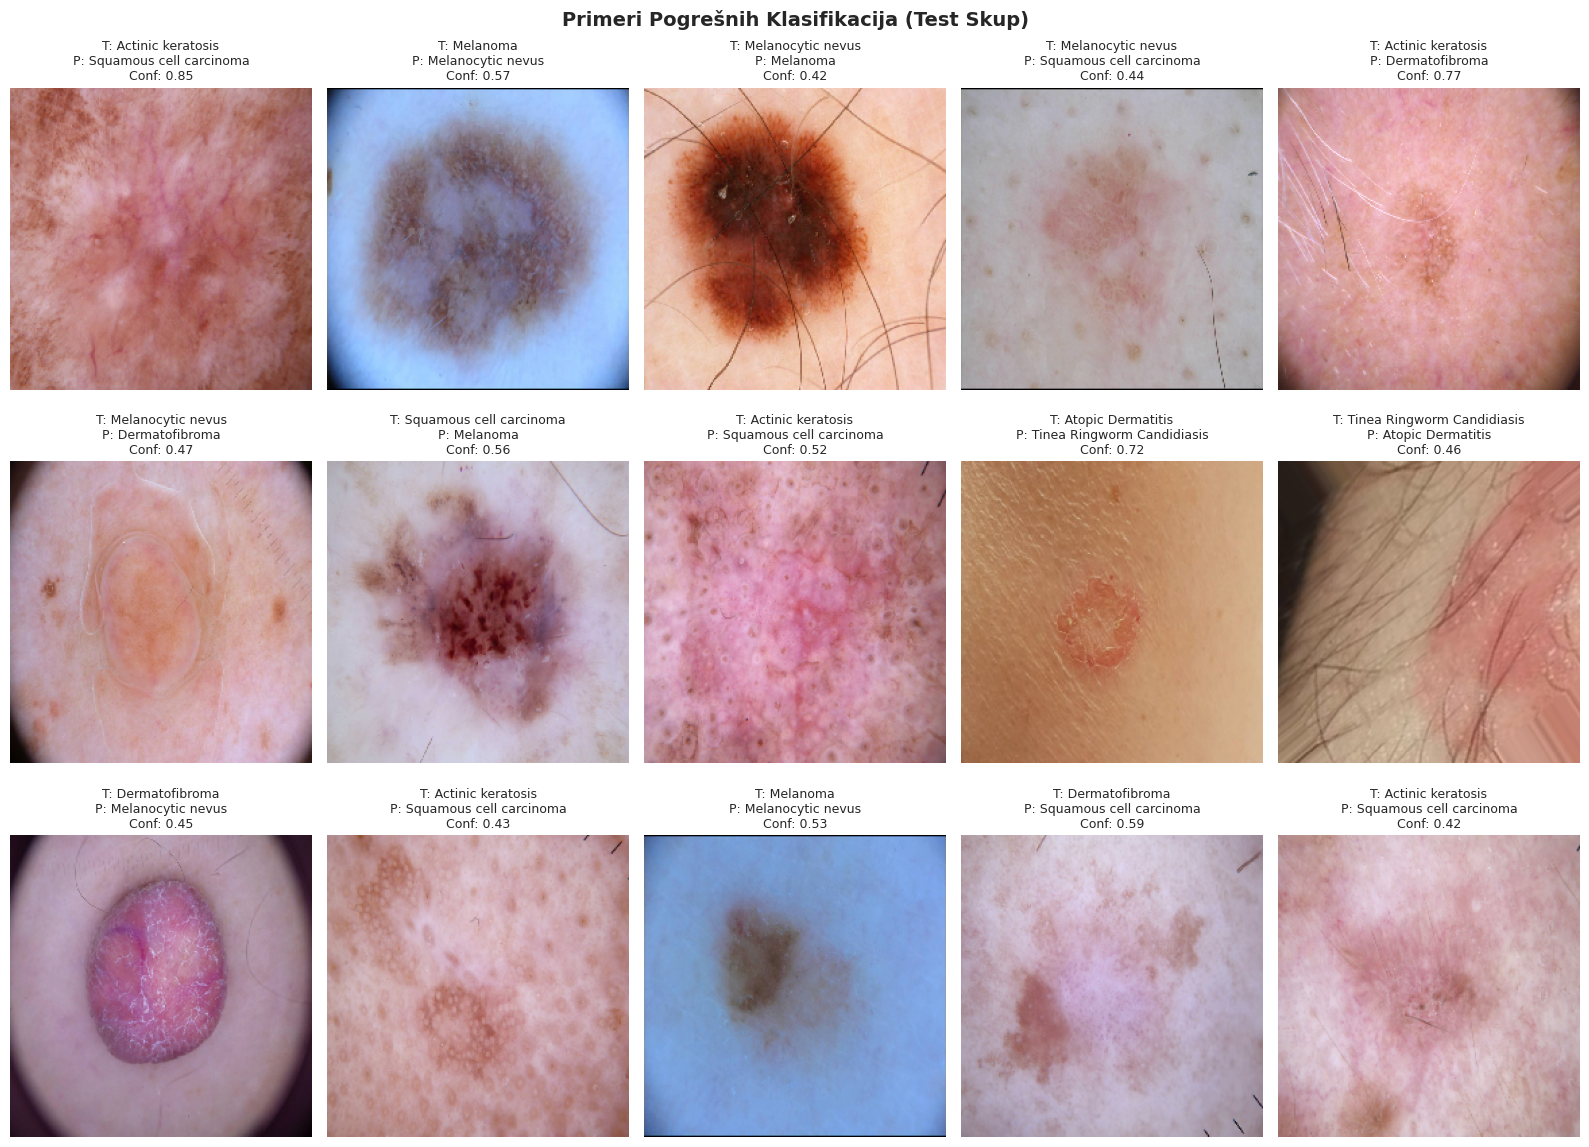

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

wrong_idx = np.where(test_pred != test_true)[0]
n_show = min(15, len(wrong_idx))

print(f"\nUkupan broj pogrešnih predikcija: {len(wrong_idx)} od {len(test_true)}")
print(f"Prikazujem: {n_show}\n")

filepaths = test_generator.filepaths

plt.figure(figsize=(16, 12))

for idx, img_idx in enumerate(wrong_idx[:n_show]):
    img_path = filepaths[img_idx]
    img = load_img(img_path, target_size=IMG_SIZE)
    x = img_to_array(img) / 255.0

    true_cls = CLASS_NAMES[test_true[img_idx]]
    pred_cls = CLASS_NAMES[test_pred[img_idx]]
    confidence = test_pred_probs[img_idx].max()

    plt.subplot(3, 5, idx + 1)
    plt.imshow(x.astype('float32'))
    plt.title(f'T: {true_cls}\nP: {pred_cls}\nConf: {confidence:.2f}', fontsize=9)
    plt.axis('off')

plt.suptitle('Primeri Pogrešnih Klasifikacija (Test Skup)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 15. Analiza performansi po klasama

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(
    test_true, test_pred,
    average=None,
    labels=range(NUM_CLASSES)
)

metrics_df = pd.DataFrame({
    'Klasa': CLASS_NAMES,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

print("\nMETRIKE PO KLASAMA (Test Skup):\n")
print(metrics_df.to_string(index=False))
print(f"\nProsečna Precision: {precision.mean():.4f}")
print(f"Prosečan Recall: {recall.mean():.4f}")
print(f"Prosečan F1-Score: {f1.mean():.4f}")


METRIKE PO KLASAMA (Test Skup):

                     Klasa  Precision   Recall  F1-Score
         Actinic keratosis   0.666667 0.533333  0.592593
         Atopic Dermatitis   0.933333 0.875000  0.903226
          Benign keratosis   1.000000 0.933333  0.965517
            Dermatofibroma   0.642857 0.600000  0.620690
         Melanocytic nevus   0.545455 0.400000  0.461538
                  Melanoma   0.647059 0.733333  0.687500
   Squamous cell carcinoma   0.454545 0.666667  0.540541
Tinea Ringworm Candidiasis   0.909091 0.909091  0.909091
           Vascular lesion   0.812500 0.866667  0.838710

Prosečna Precision: 0.7346
Prosečan Recall: 0.7242
Prosečan F1-Score: 0.7244


### 17. Vizuelizacija metrika po klasama

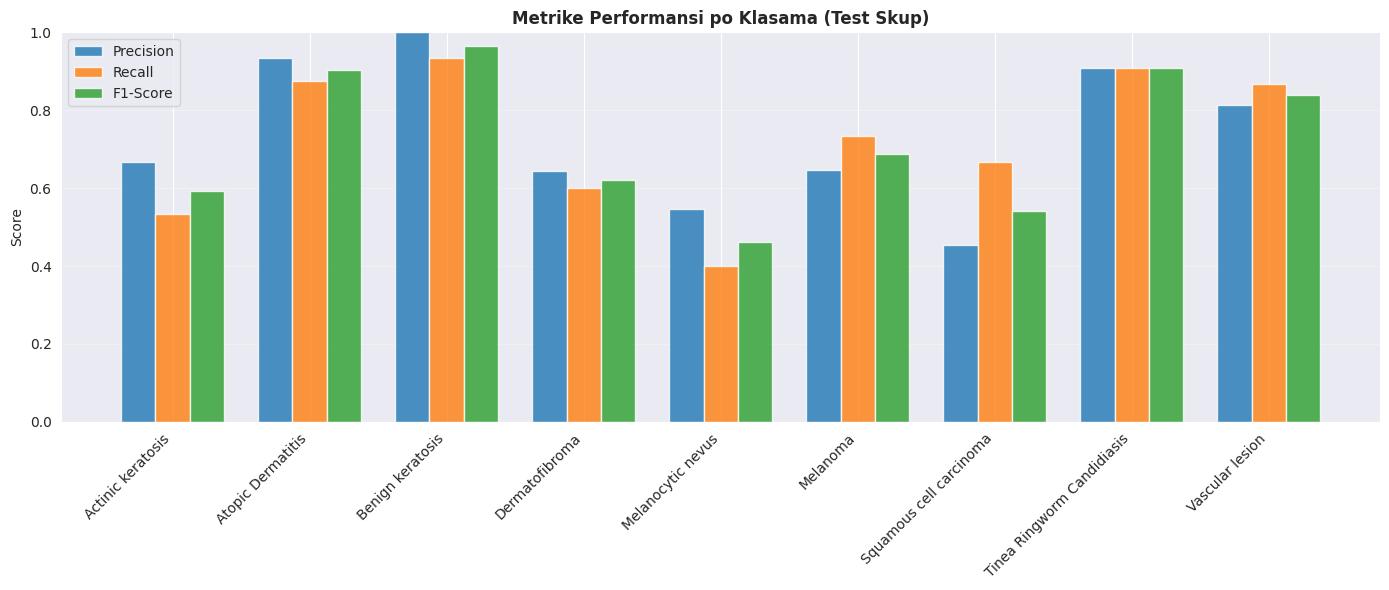

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(CLASS_NAMES))
width = 0.25

ax.bar(x - width, precision, width, label='Precision', alpha=0.8)
ax.bar(x, recall, width, label='Recall', alpha=0.8)
ax.bar(x + width, f1, width, label='F1-Score', alpha=0.8)

ax.set_ylabel('Score')
ax.set_title('Metrike Performansi po Klasama (Test Skup)', fontweight='bold', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(CLASS_NAMES, rotation=45, ha='right')
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 18. Zaključak

Na osnovu sprovedenih eksperimenata može se zaključiti da je primena transfer učenja sa ResNet50 arhitekturom predstavljala efikasan pristup za problem klasifikacije kožnih oboljenja na relativno malom skupu podataka. U poređenju sa baseline CNN modelom iz prethodne faze rada, ostvaren je značajan napredak u performansama, čime je potvrđena opravdanost izbora pretreniranog modela.

Model je na validacionom skupu postigao tačnost od 78.03%, dok je na potpuno odvojenom test skupu ostvarena tačnost od 71.97%. Iako je prisutan blagi pad performansi između validacije i testa, rezultati ukazuju na solidnu sposobnost generalizacije. Prosečan F1-score na test skupu iznosi 0.7244, što pokazuje relativno uravnotežen odnos između preciznosti i odziva.

Analiza po klasama otkriva da model veoma dobro prepoznaje određene dijagnoze, poput Benign keratosis, Tinea Ringworm Candidiasis i Atopic Dermatitis, dok su najveći izazovi prisutni kod vizuelno sličnih lezija, posebno Melanocytic nevus i Squamous cell carcinoma. Posebno je važno istaći da recall za klasu Melanoma iznosi 0.7333, što znači da model uspešno prepoznaje većinu malignih slučajeva, ali i dalje postoji prostor za unapređenje kako bi se smanjio broj propuštenih dijagnoza.

ROC-AUC analiza dodatno potvrđuje visoku diskriminativnu sposobnost modela, sa prosečnom vrednošću 0.9648, što ukazuje da model generalno dobro razdvaja klase kroz različite pragove odlučivanja.

Ukupno posmatrano, model pokazuje stabilne i obećavajuće performanse, ali i jasno definiše ograničenja – pre svega u razlikovanju vizuelno sličnih pigmentnih i malignih lezija. Dalja unapređenja mogla bi uključivati proširenje skupa podataka, primenu naprednijih arhitektura ili ensemble pristupa, kao i dodatne tehnike regularizacije i optimizacije.

Rezultati ovog rada potvrđuju da transfer learning predstavlja snažan i praktično primenljiv pristup u domenu medicinske klasifikacije slika, ali da konačna klinička primena zahteva dodatna istraživanja i validaciju na većim i raznovrsnijim dataset-ima.
